In [36]:
import geopy
import pandas as pd
import numpy as np

from pyproj import Geod
from shapely.geometry import Point, LineString
from sklearn.cluster import DBSCAN

X = pd.read_csv('data/stores_train.csv')
X_extra = pd.read_csv('data/stores_extra.csv')
X_full = pd.concat([X, X_extra], axis=0)
print(X_full.shape)
spatial = pd.read_csv('data/grunnkrets_norway_stripped.csv')
age = pd.read_csv('data/grunnkrets_age_distribution.csv')

(41543, 12)


{-1: 6607, 0: 16460, 1: 452, 2: 1714, 3: 2467, 4: 182, 5: 2962, 6: 112, 7: 357, 8: 244, 9: 189, 10: 269, 11: 135, 12: 853, 13: 617, 14: 102, 15: 669, 16: 1057, 17: 1087, 18: 526, 19: 116, 20: 184, 21: 338, 22: 114, 23: 127, 24: 815, 25: 129, 26: 640, 27: 170, 28: 130, 29: 208, 30: 167, 31: 192, 32: 125, 33: 170, 34: 172, 35: 177, 36: 241, 37: 154, 38: 113}
40


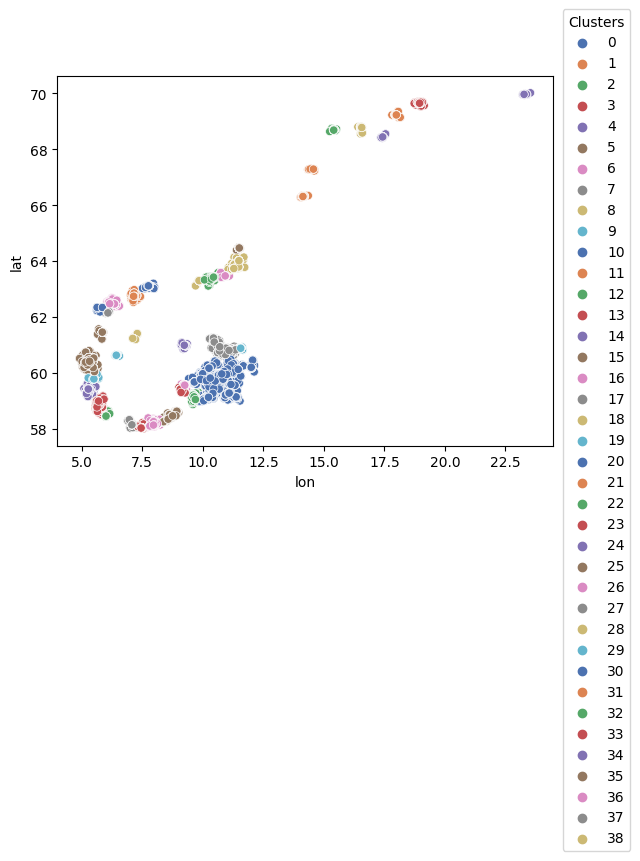

In [96]:
import seaborn as sns
import matplotlib.pyplot as plt

clusters = DBSCAN(eps=0.145, min_samples=100)
# clusters.fit(X_full[['lat', 'lon']].to_numpy())
# X_full['cluster'] = X_full.apply(
#     lambda row: clusters.fit_predict(X_full[['lat', 'lon']].to_numpy()), axis=1)

cl = clusters.fit_predict(X_full[['lat', 'lon']].to_numpy())
cl_counts = dict(zip(*np.unique(cl, return_counts=True)))
print(cl_counts)
print(len(set(cl)))

X_full['cluster_id'] = cl
# X_full['cluster_member_count'] = 
X_full.head()


# print(len(set(clusters.labels_)))
# print(len(clusters.components_))

# X_full.head()

X_no_outliers = X_full[X_full.cluster_id != -1]
cluster_centroids = X_no_outliers.groupby('cluster_id')[['lat', 'lon']].mean()

concatenated = pd.concat([
    # X_no_outliers.assign(dataset='clusters'),
    cluster_centroids.assign(dataset='centroids'),
])
p = sns.scatterplot(data=X_no_outliers, x="lon", y="lat", hue=X_no_outliers.cluster_id, legend="full", palette="deep")
sns.move_legend(p, "upper right", bbox_to_anchor=(1.17, 1.2), title='Clusters')
plt.show()

# p = sns.scatterplot(data=concatenated, x="lon", y="lat", hue='cluster_id', style='dataset')
# # sns.move_legend(p, "upper right", bbox_to_anchor=(1.17, 1.2), title='Clusters')
# plt.show()

In [ ]:
gk_muni = spatial[['grunnkrets_id', 'municipality_name']]

old_shape = X.shape
# print(len(X.merge(gk_muni, on='grunnkrets_id', how='right')))
X = X.merge(gk_muni, on='grunnkrets_id', how='left')

_ = X.groupby(['municipality_name'])['lat', 'lon'].apply(lambda x: x.sum() / (x.count()))[['lat', 'lon']]
X = X.merge(_, on=['municipality_name'], how='left', suffixes=(None, '_center')).drop_duplicates()
assert X.shape[0] == old_shape[0]

def meter_distance(lat1, lon1, lat2, lon2):
    line_string = LineString([Point(lon1, lat1), Point(lon2, lat2)])
    geod = Geod(ellps="WGS84")
    return geod.geometry_length(line_string)


X.fillna(value={'lat_center': 63, 'lon_center': 10}, inplace=True)
X.isnull().sum()

X['dist_to_center'] = X.apply(lambda row: meter_distance(row.lat, row.lon, row.lat_center, row.lon_center), axis=1)
X[20:30]

assert X.shape[0] == old_shape[0]



44616
store_id                   0
year                       0
store_name                 0
plaace_hierarchy_id        0
sales_channel_name         0
grunnkrets_id              0
address                 3537
lat                        0
lon                        0
chain_name             18223
mall_name              21128
revenue                    0
municipality_name         30
dtype: int64
(25688, 13)


C:\Users\oskar\AppData\Local\Temp/ipykernel_32224/570308066.py:10: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  _ = X.groupby(['municipality_name'])['lat', 'lon'].apply(lambda x: x.sum() / (x.count()))[['lat', 'lon']]


                         lat        lon
municipality_name                      
Agdenes            63.614633   9.648959
Alstahaug          66.015404  12.616322
Alta               69.961071  23.278242
Alvdal             62.124834  10.622663
Andebu             59.260275  10.155347
...                      ...        ...
Østre Toten        60.665598  10.849315
Øvre Eiker         59.773444   9.897019
Øyer               61.239738  10.450549
Øygarden           60.543227   4.888164
Øystre Slidre      61.230820   8.926223

[410 rows x 2 columns]


In [ ]:
X[['municipality_name', 'lat_center']]


,municipality_name,lat_center
0,Drammen,59.740315
2,Oslo,59.919972
4,Ringerike,60.176006
6,Bodø,67.283052
8,Trondheim,63.418063
...,...,...
25678,Horten,59.404396
25680,Gjøvik,60.806942
25682,Skedsmo,59.957614
25684,Sandnes,58.857718
